## Day 80 Lecture 2 Assignment

In this assignment, we will learn how to use the other layers to improve our model performance.

In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

We will explore a dataset containing information about twitter users and will detect whether or not the user is a bot.

In [2]:
twitter = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/training_data_2_csv_UTF.csv')

In [3]:
twitter.head()

,id,id_str,screen_name,location,description,url,followers_count,friends_count,listed_count,created_at,favourites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name,bot
0,8.160000e+17,"""815745789754417152""","""HoustonPokeMap""","""Houston, TX""","""Rare and strong PokŽmon in Houston, TX. See m...","""https://t.co/dnWuDbFRkt""",1291,0,10,"""Mon Jan 02 02:25:26 +0000 2017""",0,False,78554,"""en""","{\r ""created_at"": ""Sun Mar 12 15:44:04 +0...",True,False,False,"""Houston PokŽ Alert""",1
1,4.843621e+09,4843621225,kernyeahx,"Templeville town, MD, USA",From late 2014 Socium Marketplace will make sh...,NaN,1,349,0,2/1/2016 7:37,38,False,31,en,NaN,True,False,False,Keri Nelson,1
2,4.303727e+09,4303727112,mattlieberisbot,NaN,"Inspired by the smart, funny folks at @replyal...",https://t.co/P1e1o0m4KC,1086,0,14,Fri Nov 20 18:53:22 +0000 2015,0,False,713,en,"{'retweeted': False, 'is_quote_status': False,...",True,False,False,Matt Lieber Is Bot,1
3,3.063139e+09,3063139353,sc_papers,NaN,NaN,NaN,33,0,8,2/25/2015 20:11,0,False,676,en,Construction of human anti-tetanus single-chai...,True,True,False,single cell papers,1
4,2.955142e+09,2955142070,lucarivera16,"Dublin, United States",Inspiring cooks everywhere since 1956.,NaN,11,745,0,1/1/2015 17:44,146,False,185,en,NaN,False,False,False,lucarivera16,1


In [4]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2797 entries, 0 to 2796
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2797 non-null   float64
 1   id_str                 2797 non-null   object 
 2   screen_name            2797 non-null   object 
 3   location               1777 non-null   object 
 4   description            2394 non-null   object 
 5   url                    1455 non-null   object 
 6   followers_count        2797 non-null   int64  
 7   friends_count          2797 non-null   int64  
 8   listed_count           2797 non-null   int64  
 9   created_at             2797 non-null   object 
 10  favourites_count       2797 non-null   int64  
 11  verified               2797 non-null   bool   
 12  statuses_count         2797 non-null   int64  
 13  lang                   2797 non-null   object 
 14  status                 2508 non-null   object 
 15  defa

In [5]:
twitter.shape

(2797, 20)

Start by getting rid of all columns that are not useful.

In [6]:
twitter = twitter[list(twitter.columns[2:])]
twitter.head()

,screen_name,location,description,url,followers_count,friends_count,listed_count,created_at,favourites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name,bot
0,"""HoustonPokeMap""","""Houston, TX""","""Rare and strong PokŽmon in Houston, TX. See m...","""https://t.co/dnWuDbFRkt""",1291,0,10,"""Mon Jan 02 02:25:26 +0000 2017""",0,False,78554,"""en""","{\r ""created_at"": ""Sun Mar 12 15:44:04 +0...",True,False,False,"""Houston PokŽ Alert""",1
1,kernyeahx,"Templeville town, MD, USA",From late 2014 Socium Marketplace will make sh...,NaN,1,349,0,2/1/2016 7:37,38,False,31,en,NaN,True,False,False,Keri Nelson,1
2,mattlieberisbot,NaN,"Inspired by the smart, funny folks at @replyal...",https://t.co/P1e1o0m4KC,1086,0,14,Fri Nov 20 18:53:22 +0000 2015,0,False,713,en,"{'retweeted': False, 'is_quote_status': False,...",True,False,False,Matt Lieber Is Bot,1
3,sc_papers,NaN,NaN,NaN,33,0,8,2/25/2015 20:11,0,False,676,en,Construction of human anti-tetanus single-chai...,True,True,False,single cell papers,1
4,lucarivera16,"Dublin, United States",Inspiring cooks everywhere since 1956.,NaN,11,745,0,1/1/2015 17:44,146,False,185,en,NaN,False,False,False,lucarivera16,1


Next, get rid of all columns that contain more than 30% missing data. After that, remove all rows containing at least one missing observation.

In [7]:
twitter.isnull().mean()

screen_name              0.000000
location                 0.364676
description              0.144083
url                      0.479800
followers_count          0.000000
friends_count            0.000000
listed_count             0.000000
created_at               0.000000
favourites_count         0.000000
verified                 0.000000
statuses_count           0.000000
lang                     0.000000
status                   0.103325
default_profile          0.000000
default_profile_image    0.000000
has_extended_profile     0.035395
name                     0.000000
bot                      0.000000
dtype: float64

In [8]:
limitPer = len(twitter) * .70
twitter.dropna(thresh=limitPer, axis=1, inplace=True)
twitter.isnull().mean()

screen_name              0.000000
description              0.144083
followers_count          0.000000
friends_count            0.000000
listed_count             0.000000
created_at               0.000000
favourites_count         0.000000
verified                 0.000000
statuses_count           0.000000
lang                     0.000000
status                   0.103325
default_profile          0.000000
default_profile_image    0.000000
has_extended_profile     0.035395
name                     0.000000
bot                      0.000000
dtype: float64

In [9]:
twitter.dropna(inplace=True)

Now we will use our embedding functions from a previous assignment.

In [10]:
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words)       

def stem_list(word_list):
    stemmed = []
    for word in word_list:
        stemmedword = stemmer.stem(word)
        stemmed.append(stemmedword)
    return stemmed

def normalize(terms):
    terms = terms.lower()
    terms = remove_stopwords(terms)
    word_delimiters = u'[\\[\\]\n.!?,;:\t\\-\\"\\(\\)\\\'\u2019\u2013 ]'
    term_list = re.split(word_delimiters, terms)
    trimmed = [x.rstrip() for x in term_list]
    stemmed = stem_list(trimmed)
    space = ' '
    normed = space.join(stemmed)
    normed = normed.replace('  ', ' ')
    return normed

We will create two branches, one branch will process the text data in the description and the other will process all other columns. First, create a numpy array with the encoded data from the description column. Normalize each description, one hot encode the text, pad the row and create a numpy array.

In [11]:
import nltk
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
twitter['normalized'] = twitter.description.apply(lambda x: normalize(x))
twitter.head()

,screen_name,description,followers_count,friends_count,listed_count,created_at,favourites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name,bot,normalized
0,"""HoustonPokeMap""","""Rare and strong PokŽmon in Houston, TX. See m...",1291,0,10,"""Mon Jan 02 02:25:26 +0000 2017""",0,False,78554,"""en""","{\r ""created_at"": ""Sun Mar 12 15:44:04 +0...",True,False,False,"""Houston PokŽ Alert""",1,rare strong pokžmon houston tx see pokžmon ht...
2,mattlieberisbot,"Inspired by the smart, funny folks at @replyal...",1086,0,14,Fri Nov 20 18:53:22 +0000 2015,0,False,713,en,"{'retweeted': False, 'is_quote_status': False,...",True,False,False,Matt Lieber Is Bot,1,inspir smart funni folk @replyal @gimletmedia ...
5,dantheimprover,Just a guy trying to do good by telling everyo...,1,186,0,13/03/2017 22:53,0,False,11,en,Status(_api=<tweepy.api.API object at 0x101927...,True,False,True,dantheimprover,1,guy tri good tell everyon els get better
6,_all_of_us_,bot by @rubicon,193,0,19,Wed May 07 22:29:25 +0000 2014,0,False,6068,en,"{u'contributors': None, u'truncated': False, u...",False,False,False,everything always,1,bot @rubicon
7,KatamariItems,[Bot rolled up by @BeachEpisode] Cataloguing e...,8227,2,89,Thu Jun 18 22:07:31 +0000 2015,26,False,2597,en,"{u'contributors': None, u'truncated': False, u...",True,False,False,Katamari Collection,1,bot roll @beachepisod catalogu everi item kat...


In [13]:
words = []
for doc in twitter.normalized:
    for word in word_tokenize(doc):
        words.append(word)

unique = set(words)
unique_words = len(unique)
unique_words

7253

In [14]:
encoded_text = [one_hot(doc, unique_words) for doc in twitter.normalized]
encoded_text[0:2]

[[5886, 3113, 2945, 5329, 7150, 1350, 2945, 6512, 2463, 5145, 5584],
 [4810,
  5264,
  2377,
  4799,
  2650,
  1192,
  7003,
  2999,
  6806,
  3435,
  197,
  7003,
  5528,
  4793]]

In [15]:
ind_vars = pad_sequences(encoded_text)

In [16]:
ind_vars[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       5886, 3113, 2945, 5329, 7150, 1350, 2945, 6512, 2463, 5145, 5584],
      dtype=int32)

Convert all boolean variables to numeric (zero for false and 1 for true)

In [17]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2121 entries, 0 to 2796
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   screen_name            2121 non-null   object
 1   description            2121 non-null   object
 2   followers_count        2121 non-null   int64 
 3   friends_count          2121 non-null   int64 
 4   listed_count           2121 non-null   int64 
 5   created_at             2121 non-null   object
 6   favourites_count       2121 non-null   int64 
 7   verified               2121 non-null   bool  
 8   statuses_count         2121 non-null   int64 
 9   lang                   2121 non-null   object
 10  status                 2121 non-null   object
 11  default_profile        2121 non-null   bool  
 12  default_profile_image  2121 non-null   bool  
 13  has_extended_profile   2121 non-null   object
 14  name                   2121 non-null   object
 15  bot                  

In [18]:
twitter.has_extended_profile = twitter.has_extended_profile.astype("bool")

In [19]:
bools = twitter.select_dtypes(include="bool").columns

In [20]:
for col in bools:
    twitter[col] = twitter[col]+0

twitter.head()

,screen_name,description,followers_count,friends_count,listed_count,created_at,favourites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name,bot,normalized
0,"""HoustonPokeMap""","""Rare and strong PokŽmon in Houston, TX. See m...",1291,0,10,"""Mon Jan 02 02:25:26 +0000 2017""",0,0,78554,"""en""","{\r ""created_at"": ""Sun Mar 12 15:44:04 +0...",1,0,0,"""Houston PokŽ Alert""",1,rare strong pokžmon houston tx see pokžmon ht...
2,mattlieberisbot,"Inspired by the smart, funny folks at @replyal...",1086,0,14,Fri Nov 20 18:53:22 +0000 2015,0,0,713,en,"{'retweeted': False, 'is_quote_status': False,...",1,0,0,Matt Lieber Is Bot,1,inspir smart funni folk @replyal @gimletmedia ...
5,dantheimprover,Just a guy trying to do good by telling everyo...,1,186,0,13/03/2017 22:53,0,0,11,en,Status(_api=<tweepy.api.API object at 0x101927...,1,0,1,dantheimprover,1,guy tri good tell everyon els get better
6,_all_of_us_,bot by @rubicon,193,0,19,Wed May 07 22:29:25 +0000 2014,0,0,6068,en,"{u'contributors': None, u'truncated': False, u...",0,0,0,everything always,1,bot @rubicon
7,KatamariItems,[Bot rolled up by @BeachEpisode] Cataloguing e...,8227,2,89,Thu Jun 18 22:07:31 +0000 2015,26,0,2597,en,"{u'contributors': None, u'truncated': False, u...",1,0,0,Katamari Collection,1,bot roll @beachepisod catalogu everi item kat...


Create dummy variables out of the relevant object columns. Take caution when converting columns that may incorrectly classified as object.

In [21]:
twitter = pd.get_dummies(twitter, columns=["lang"], drop_first=True)
twitter.head()

,screen_name,description,followers_count,friends_count,listed_count,created_at,favourites_count,verified,statuses_count,status,default_profile,default_profile_image,has_extended_profile,name,bot,normalized,"lang_""en""","lang_""en-gb""","lang_""es""","lang_""fr""","lang_""it""","lang_""ja""","lang_""ko""","lang_""pt""","lang_""zh-CN""","lang_""zh-cn""",lang_ar,lang_de,lang_en,lang_en-gb,lang_es,lang_fr,lang_gl,lang_it,lang_ja,lang_nl,lang_pt,lang_ru,lang_ta,lang_tr,lang_zh-CN,lang_zh-cn
0,"""HoustonPokeMap""","""Rare and strong PokŽmon in Houston, TX. See m...",1291,0,10,"""Mon Jan 02 02:25:26 +0000 2017""",0,0,78554,"{\r ""created_at"": ""Sun Mar 12 15:44:04 +0...",1,0,0,"""Houston PokŽ Alert""",1,rare strong pokžmon houston tx see pokžmon ht...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,mattlieberisbot,"Inspired by the smart, funny folks at @replyal...",1086,0,14,Fri Nov 20 18:53:22 +0000 2015,0,0,713,"{'retweeted': False, 'is_quote_status': False,...",1,0,0,Matt Lieber Is Bot,1,inspir smart funni folk @replyal @gimletmedia ...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,dantheimprover,Just a guy trying to do good by telling everyo...,1,186,0,13/03/2017 22:53,0,0,11,Status(_api=<tweepy.api.API object at 0x101927...,1,0,1,dantheimprover,1,guy tri good tell everyon els get better,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,_all_of_us_,bot by @rubicon,193,0,19,Wed May 07 22:29:25 +0000 2014,0,0,6068,"{u'contributors': None, u'truncated': False, u...",0,0,0,everything always,1,bot @rubicon,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7,KatamariItems,[Bot rolled up by @BeachEpisode] Cataloguing e...,8227,2,89,Thu Jun 18 22:07:31 +0000 2015,26,0,2597,"{u'contributors': None, u'truncated': False, u...",1,0,0,Katamari Collection,1,bot roll @beachepisod catalogu everi item kat...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Min max scale the data decribing each user (do not min max scale the word embeddings).

In [22]:
from sklearn.preprocessing import MinMaxScaler

to_scale = ["followers_count", "friends_count", "listed_count",
            "favourites_count", "verified", "statuses_count"]
mms = MinMaxScaler()
twitter[to_scale] = mms.fit_transform(twitter[to_scale])

In [23]:
twitter.head()

,screen_name,description,followers_count,friends_count,listed_count,created_at,favourites_count,verified,statuses_count,status,default_profile,default_profile_image,has_extended_profile,name,bot,normalized,"lang_""en""","lang_""en-gb""","lang_""es""","lang_""fr""","lang_""it""","lang_""ja""","lang_""ko""","lang_""pt""","lang_""zh-CN""","lang_""zh-cn""",lang_ar,lang_de,lang_en,lang_en-gb,lang_es,lang_fr,lang_gl,lang_it,lang_ja,lang_nl,lang_pt,lang_ru,lang_ta,lang_tr,lang_zh-CN,lang_zh-cn
0,"""HoustonPokeMap""","""Rare and strong PokŽmon in Houston, TX. See m...",1.340302e-05,0.000000,0.000016,"""Mon Jan 02 02:25:26 +0000 2017""",0.000000,0.0,0.011445,"{\r ""created_at"": ""Sun Mar 12 15:44:04 +0...",1,0,0,"""Houston PokŽ Alert""",1,rare strong pokžmon houston tx see pokžmon ht...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,mattlieberisbot,"Inspired by the smart, funny folks at @replyal...",1.127473e-05,0.000000,0.000023,Fri Nov 20 18:53:22 +0000 2015,0.000000,0.0,0.000104,"{'retweeted': False, 'is_quote_status': False,...",1,0,0,Matt Lieber Is Bot,1,inspir smart funni folk @replyal @gimletmedia ...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,dantheimprover,Just a guy trying to do good by telling everyo...,1.038189e-08,0.000189,0.000000,13/03/2017 22:53,0.000000,0.0,0.000001,Status(_api=<tweepy.api.API object at 0x101927...,1,0,1,dantheimprover,1,guy tri good tell everyon els get better,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,_all_of_us_,bot by @rubicon,2.003705e-06,0.000000,0.000031,Wed May 07 22:29:25 +0000 2014,0.000000,0.0,0.000884,"{u'contributors': None, u'truncated': False, u...",0,0,0,everything always,1,bot @rubicon,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7,KatamariItems,[Bot rolled up by @BeachEpisode] Cataloguing e...,8.541182e-05,0.000002,0.000143,Thu Jun 18 22:07:31 +0000 2015,0.000036,0.0,0.000378,"{u'contributors': None, u'truncated': False, u...",1,0,0,Katamari Collection,1,bot roll @beachepisod catalogu everi item kat...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Now we'll create the two branches. Create a model for the numeric data that consists of 3 dense layers. An input layer and two hidden layers of size 32.

In [24]:
input_1 = twitter.select_dtypes("number").drop(columns=["bot"])
input_2 = ind_vars

In [25]:
from sklearn.model_selection import train_test_split as tts

# train-test split
X_train_1, X_test_1, y_train_1, y_test_1 = tts(input_1, twitter.bot, test_size=0.2, random_state=117)
X_train_2, X_test_2, y_train_2, y_test_2 = tts(input_2, twitter.bot, test_size=0.2, random_state=117)

In [26]:
from tensorflow.keras.layers import LSTM, Embedding, Flatten, Dropout, concatenate
from tensorflow.keras.utils import plot_model
# 1I2O

# first branch
# input layer
input_layer_1 = Input(shape=X_train_1.shape[1],)
# hidden layers
path1_1 = Dense(32, activation='relu')(input_layer_1)
path1_2 = Dense(32, activation='relu')(path1_1)
#flat1 = Flatten()(path1_2)

Create the second branch of the model using the encoded words. This branch will consist of 4 layers: An input layer, an embedding layer returning data of dimension 100, an LSTM layer of unit size 32 and a dense layer of unit size 32. 

In [27]:
# second branch
# input layer
input_layer_2 = Input(shape=X_train_2.shape[1],)
# embedding
embed_1 = Embedding(unique_words, 100)(input_layer_2)
lstm_1 = LSTM(32)(embed_1)
# hidden layer
path2_1 = Dense(32, activation='relu')(lstm_1)
#flat2 = Flatten()(path2_1)

Merge the two models using the `concatenate` function (merge the two final dense layers in each branch) and create an output dense layer.

In [28]:
merge = concatenate([path1_2, path2_1])
output = Dense(1, activation='sigmoid')(merge)

Create a model using the two inputs and the single output and print the summary

In [29]:
model = Model(inputs=[input_layer_1, input_layer_2], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 66)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 66, 100)      725300      input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           1152        input_1[0][0]                    
______________________________________________________________________________________________

Compile and fit the model using the appropriate optimizer, loss, and metrics. Train the model for 10 epochs with a batch size of 128.

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(x=[X_train_1, X_train_2], y=y_train_1, epochs=10, batch_size=128, validation_data=([X_test_1, X_test_2], y_test_1))

Epoch 1/10
14/14 [==============================] - 2s 52ms/step - loss: 0.6774 - accuracy: 0.7278 - val_loss: 0.6502 - val_accuracy: 0.7012
Epoch 2/10
14/14 [==============================] - 0s 18ms/step - loss: 0.6306 - accuracy: 0.7501 - val_loss: 0.5888 - val_accuracy: 0.7694
Epoch 3/10
14/14 [==============================] - 0s 18ms/step - loss: 0.5310 - accuracy: 0.8284 - val_loss: 0.4787 - val_accuracy: 0.8071
Epoch 4/10
14/14 [==============================] - 0s 17ms/step - loss: 0.3334 - accuracy: 0.9113 - val_loss: 0.4586 - val_accuracy: 0.8000
Epoch 5/10
14/14 [==============================] - 0s 18ms/step - loss: 0.2015 - accuracy: 0.9405 - val_loss: 0.3713 - val_accuracy: 0.8447
Epoch 6/10
14/14 [==============================] - 0s 18ms/step - loss: 0.1031 - accuracy: 0.9782 - val_loss: 0.4030 - val_accuracy: 0.8424
Epoch 7/10
14/14 [==============================] - 0s 17ms/step - loss: 0.0575 - accuracy: 0.9910 - val_loss: 0.4898 - val_accuracy: 0.8329
Epoch 8/10
14

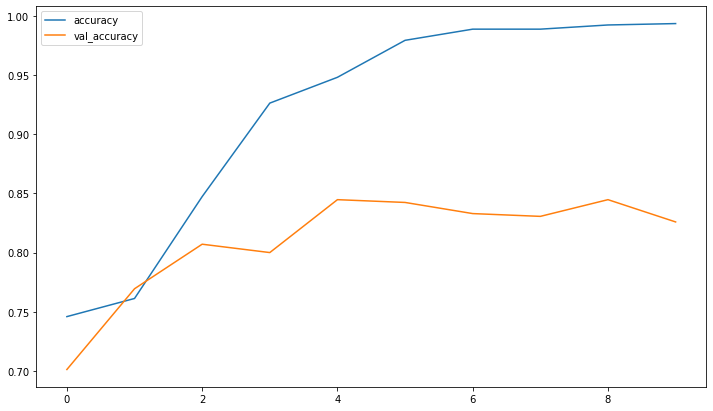

In [41]:
import matplotlib.pyplot as plt

res = pd.DataFrame(hist.history)

res[["accuracy", "val_accuracy"]].plot(figsize=(12,7))

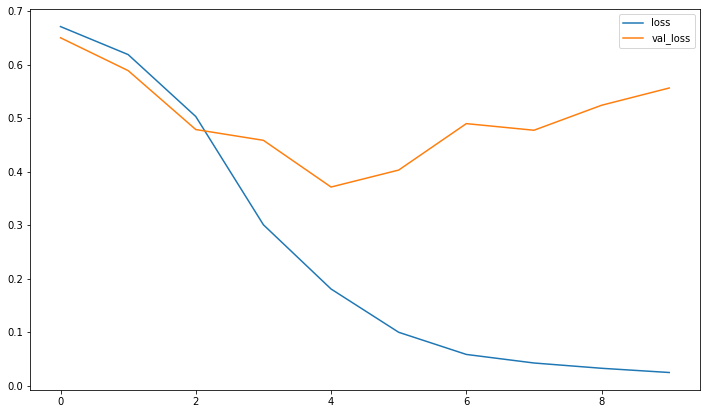

In [42]:
res[["loss", "val_loss"]].plot(figsize=(12,7))